In [1]:
# import pandas as pd
# import numpy as np
import collections

import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from ANP import *

import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
SMOKE_TEST = os.environ.get("SMOKE_TEST")

import warnings
warnings.filterwarnings("ignore")

c:\Users\82109\anaconda3\envs\botorch_ex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fun = Ackley(dim=20, negate=True).to(dtype=dtype, device=device)
fun.bounds[0, :].fill_(-5)
fun.bounds[1, :].fill_(10)
dim = fun.dim
lb, ub = fun.bounds
print(dim)

batch_size = 4
n_init = 2 * dim
max_cholesky_size = float("inf")  # Always use Cholesky

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4

20


In [3]:
def eval_objective(x):
    """This is a helper function we use to unnormalize and evalaute a point"""
    return fun(unnormalize(x, fun.bounds))

def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = sobol.draw(n=n_pts).to(dtype=dtype, device=device)
    return X_init

### GP-EI

In [28]:
# NUM_RESTARTS = 2
# RAW_SAMPLES = 4
# N_CANDIDATES = 4

torch.manual_seed(0)

X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor(
    [eval_objective(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)

while len(Y_ei) < 400:
    train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # Create a batch
    ei = qExpectedImprovement(model, train_Y.max())
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,
    )
    print(candidate.size())
    break
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_ei = torch.cat((X_ei, candidate), axis=0)
    Y_ei = torch.cat((Y_ei, Y_next), axis=0)
    # print(X_ei.size(), Y_ei.size())

    # Print current status
    print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

torch.Size([4, 20])


### NP-MC

In [7]:
import glob
import numpy as np
import torch
from math import pi
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

class My_Ackley(Dataset):
    def __init__(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y

        # Generate data
        self.data = []
        self.data.append((self.train_x, self.train_y))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [5]:
# class My_Ackley(Dataset):
#     def __init__(self, train_x, train_y):
#         self.train_x = train_x
#         self.train_y = train_y

#         # Generate data
#         self.data = []
#         self.data.append((self.train_x, self.train_y))

#         self.num_samples = self.train_x.size()[0]

#     def __getitem__(self, index):
#         return self.train_x[index], self.train_y[index]

#     def __len__(self):
#         return self.num_samples

In [6]:
## bo
from torch.utils.data import DataLoader
from neural_process import NeuralProcess
from training import NeuralProcessTrainer
from botorch.sampling.normal import SobolQMCNormalSampler
from utils import context_target_split
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.acquisition.objective import IdentityMCObjective

## NP model
x_dim = 20
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder
neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

train_batch_size = 4
num_context = 4
num_target = 4
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=100)

torch.manual_seed(0)

X_np = get_initial_points(dim, n_init)
Y_np = torch.tensor(
    [eval_objective(x) for x in X_np], dtype=dtype, device=device
).unsqueeze(-1)

sampler = StochasticSampler(torch.Size([4]), seed=1234)
obj = IdentityMCObjective()

while len(Y_np) < 400:
    best_f = Y_np.max() 
    train_Y = (Y_np - Y_np.mean()) / Y_np.std()
    ackley_dataset = My_Ackley(train_x = X_np, train_y = train_Y)
    data_loader = DataLoader(ackley_dataset, batch_size=train_batch_size, shuffle=True)

    neuralprocess.training = True
    np_trainer.train(data_loader, 200)

    # Create a batch
    neuralprocess.training = False
    x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                    num_context, 
                                                    num_target)
    neuralprocess.set_context_for_posterior(x_context, y_context)

    ei = qExpectedImprovement(neuralprocess, best_f, sampler, obj)
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size, # The number of candidates
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, # The number of samples for initialization.
    )
    # break
    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_np = torch.cat((X_np, candidate), axis=0)
    Y_np = torch.cat((Y_np, Y_next), axis=0)

    # Print current status
    print(f"{len(X_np)}) Best value: {Y_np.max().item():.2e}")

ValueError: Cannot take a larger sample than population when 'replace=False'

In [19]:
## bo
from torch.utils.data import DataLoader
from neural_process import NeuralProcess
from training import NeuralProcessTrainer
from botorch.sampling.normal import SobolQMCNormalSampler
from utils import context_target_split
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.sampling.stochastic_samplers import StochasticSampler
from botorch.acquisition.objective import IdentityMCObjective

## NP model
x_dim = 20
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder
neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)

batch_size = 8
num_context = 4
num_target = 4
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=100)

torch.manual_seed(0)

X_np1 = get_initial_points(dim, n_init)
Y_np1 = torch.tensor(
    [eval_objective(x) for x in X_np1], dtype=dtype, device=device
).unsqueeze(-1)

sampler = StochasticSampler(torch.Size([4]), seed=1234)
obj = IdentityMCObjective()

while len(Y_np1) < 400:
    best_f = Y_np1.max() 
    train_Y = (Y_np1 - Y_np1.mean()) / Y_np1.std()
    ackley_dataset = My_Ackley(train_x = X_np1, train_y = train_Y)
    data_loader = DataLoader(ackley_dataset, batch_size=batch_size, shuffle=True)

    neuralprocess.training = True
    np_trainer.train(data_loader, 200)

    # Create a batch
    neuralprocess.training = False
    for batch in data_loader:
        break
    x, y = batch
    x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                    num_context, 
                                                    num_target)
    neuralprocess.set_context_for_posterior(x_context, y_context)

    ei = qExpectedImprovement(neuralprocess, train_Y.max(), sampler, obj)
    candidate, acq_value = optimize_acqf(
        ei,
        bounds=torch.stack(
            [
                torch.zeros(dim, dtype=dtype, device=device),
                torch.ones(dim, dtype=dtype, device=device),
            ]
        ),
        q=batch_size, # The number of candidates
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES, # The number of samples for initialization.
    )

    Y_next = torch.tensor(
        [eval_objective(x) for x in candidate], dtype=dtype, device=device
    ).unsqueeze(-1)

    # Append data
    X_np1 = torch.cat((X_np1, candidate), axis=0)
    Y_np1 = torch.cat((Y_np1, Y_next), axis=0)

    # Print current status
    print(f"{len(X_np1)}) Best value: {Y_np1.max().item():.2e}")

iteration 100, loss 13.068
iteration 200, loss 10.477
48) Best value: -1.24e+01
iteration 300, loss 13.173
iteration 400, loss 9.188
56) Best value: -1.20e+01
iteration 500, loss 9.597
iteration 600, loss 7.706
64) Best value: -1.20e+01
iteration 700, loss 6.620
iteration 800, loss 6.944
72) Best value: -1.20e+01
iteration 900, loss 4.916
iteration 1000, loss 5.999
80) Best value: -1.20e+01
iteration 1100, loss 6.230
iteration 1200, loss 7.123
88) Best value: -1.18e+01
iteration 1300, loss 6.585
iteration 1400, loss 4.902
96) Best value: -1.18e+01
iteration 1500, loss 3.871
iteration 1600, loss 3.968
104) Best value: -1.18e+01
iteration 1700, loss 8.005
iteration 1800, loss 5.709
112) Best value: -1.18e+01
iteration 1900, loss 10.504
iteration 2000, loss 2.045
120) Best value: -1.18e+01
iteration 2100, loss 4.833
iteration 2200, loss 4.791
128) Best value: -1.18e+01
iteration 2300, loss 8.155
iteration 2400, loss 8.931
136) Best value: -1.09e+01
iteration 2500, loss 7.475
iteration 260

## plot

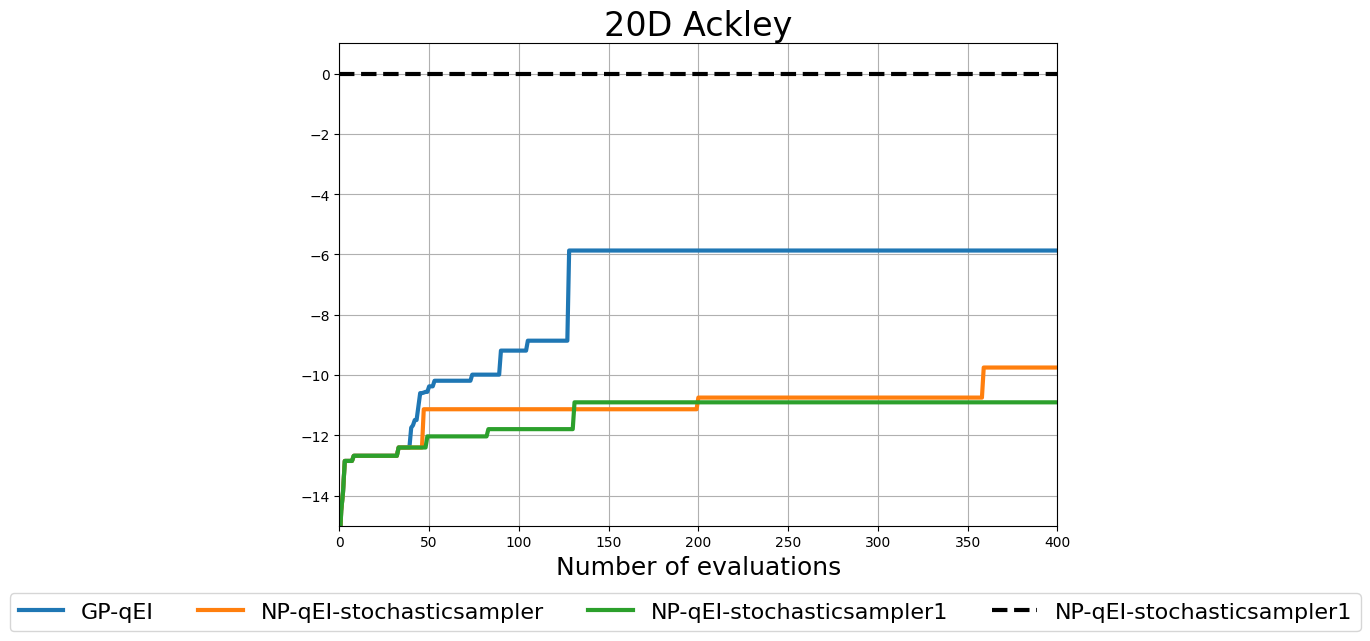

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

%matplotlib inline

names = ["GP-qEI", "NP-qEI-stochasticsampler", "NP-qEI-stochasticsampler1", "NP-qEI-stochasticsampler1"] # , "EI", "Sobol"
runs = [Y_ei, Y_np, Y_np1] # , Y_ei, Y_Sobol
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(fx, marker="", lw=3)

plt.plot([0, len(Y_ei)], [fun.optimal_value, fun.optimal_value], "k--", lw=3)
plt.xlabel("Function value", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title("20D Ackley", fontsize=24)
plt.xlim([0, len(Y_ei)])
plt.ylim([-15, 1])

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()